# Homework 09
## Brown University
## DATA 1010
## Fall 2020

## Problem 1

If we fit a kernelized SVM model using LIBSVM, then it produces a collection of values that can be used to compute the decision function (essential the prediction function, but just before we apply the signum function):

In [ ]:
using Pkg; Pkg.activate("my_MLJ_env", shared=true)
Pkg.add("MLJ")
Pkg.add("MLJScikitLearnInterface")

In [ ]:
using MLJ, Plots

In [ ]:
using Random; Random.seed!(123)
X, y = make_moons(noise = 1/4)
scatter(X.x1, X.x2, group = y, color = [:blue :red], label = "")

In [ ]:
model = @load SVMClassifier 
model.kernel = "rbf"
svm = machine(model, X, y)
fit!(svm)

In [ ]:
fitted_params(svm)

The `dual_coef` values correspond to what we're calling $\eta$ in the math notation. However, note that only the nonzero $\eta$ values are stored! To see which ones are nonzero, look at `support`. The `support_vectors` are also included, for your convenience. What we've been calling $\alpha$ corresponds to `intercept`.

Write some code which uses these values to compute the decision function (that is, from scratch, not using `_decision_function` as we did in class), and use it to plot a heatmap of the decision function. You might have to include the radial basis function manually, since that's actually hard-coded in LIBSVM.

Notes:  
(1) the course cheatsheet describes the prediction function exactly.  
(2) the knowledge you gain in this question is not Julia-specific; LIBSVM is the main library underlying SVM packages in various dynamic languages.

*Solution:*  

In [6]:
param_list = fitted_params(svm)

(support = Int32[0, 2, 13, 14, 54, 56, 58, 70, 74, 79  …  105, 106, 108, 113, 114, 118, 124, 136, 137, 148],
 support_vectors = [-0.20126506340104716 0.6450936714640432; -0.7683213589320509 0.2535325295674478; … ; 1.8397735921316891 -0.051927737212519864; -0.16939775881651062 -0.04735555463528539],
 n_support = Int32[24, 25],
 dual_coef = [-1.0 -1.0 … 0.6001591064661908 0.9086719097541197],
 coef = nothing,
 intercept = [0.09013801196728105],
 fit_status = 0,
 classes = UInt32[0x00000001, 0x00000002],)

In [7]:
# First, we define the Gaussian RBF as our kernel function
rbf_kernel(a,b;γ=0.5) = exp(-γ*sum((a-b).^2)) 

rbf_kernel (generic function with 1 method)

In [8]:
# Note the 4th element stores hadamard product between y and η, we make it a col vector
η_hdm_y = permutedims(fitted_params(svm)[4])
# Then get α the intercept
α = fitted_params(svm)[6]

1-element Array{Float64,1}:
 0.09013801196728105

In [9]:
# get indices with support vectors
support = fitted_params(svm)[1];
# use support vectors to create a feature matrix
features = hcat([X.x1[i+1] for i in support],[X.x2[i+1] for i in support]);

In [10]:
# the prediction function is essentially the a hyperplane with kernel
# We get the prediction function from data Gymnasia
function predict(feature_matrix, η_hdm_y, α, test) 
    𝒦test = permutedims([rbf_kernel(permutedims(row),test) for row in eachrow(feature_matrix)])
    (𝒦test * η_hdm_y .+ α)[1]
end

predict (generic function with 1 method)

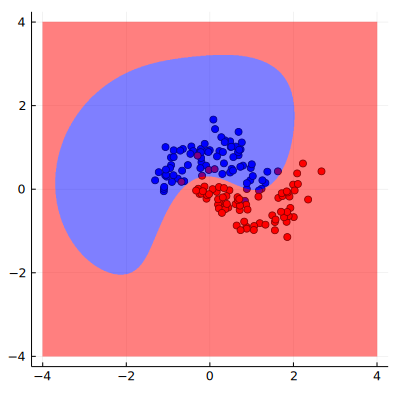

In [11]:
heatmap!(-4:0.01:4, -4:0.01:4, (x,y) -> sign((predict(features, η_hdm_y, α, [x y]))), 
    fillopacity = 0.5, colorbar = false, fontfamily = "Palatino", fillcolor = cgrad([:blue, :lightblue, :pink, :red]), 
    aspect_ratio= 1, size = (400, 400))

## Problem 2

Apply the Lagrange duality method we apply in Data Gymnasia to obtain the dual SVM to the problem of minimizing the objective function $f(x,y) = x^2 + y^2$ subject to the constraint $x + y \ge 5$. Show that strong duality holds (that is, we get the same value for the objective function if we swap min and max).

Note: this problem is asking you to walk through the same steps: introducing the function $H$, swapping min/max, etc. The only difference is that you're dealing with a much simpler optimization problem.

*Solution:*  

Just like in Data Gymnasia, we introduce the $H$ function and get: $x^2 + y^2 + H(5-x-y)$. Then we introduce $\eta$ that is bigger than or equal to zero associated to the corresponding $H$ function.

We therefore have the following minmax problem:  
$$
min_{x,y}max_{\eta \geq 0} (x^2 + y^2 + \eta(5-x-y))
$$

We first look at the maximization problem for solving $\eta$, we observe if $5-x-y > 0$, the expression blows up to infinity. Then, we look at the case when $5-x-y < 0$, we get $\eta = 0$. However, when $\eta = 0$, we'll get $x=0$ and $y=0$ when we look at the minimization problem, which does not satisfy the condition of $5-x-y < 0$. Therefore, we need to have $5 = x + y$. We then look into the minization problem, we take the differentiating step and get $x = y$. Thus we have $x = y = 2.5$ and $\eta = 5$. Therefore, the whole minmax problem has a result value of 12.5.

To show strong duality, we also need to solve for the following maxmin problem:  
$$
max_{\eta \geq 0}min_{x,y} (x^2 + y^2 + \eta(5-x-y))
$$

The inside minimization problem can be solved easily with differentiation. We'll have $x = y = \frac{\eta}{2}$. Plug this result into the maximization problem, we'll have 
$$
max_{\eta \geq 0} 5\eta - \frac{\eta^2}{2}
$$

We again use differentiation and get $\eta = 5$, and $x = y = \frac{\eta}{2} = 2.5$. Therefore the result of the maxmin problem equals 12.5 and finishes the proof.

## Problem 3

Let's take a look at the zeros and ones in the MNIST dataset:

In [12]:
Pkg.add("MLDatasets")
using MLDatasets

  Resolving package versions...
  Installed LibSSH2_jll ─ v1.9.0+3
  Installed LibCURL_jll ─ v7.70.0+2
  Installed nghttp2_jll ─ v1.40.0+2
  Installed HDF5_jll ──── v1.12.0+1
  Installed BinDeps ───── v1.0.2
  Installed MAT ───────── v0.9.2
  Installed HDF5 ──────── v0.14.3
  Installed MLDatasets ── v0.5.3
Updating `~/.julia/environments/my_MLJ_env/Project.toml`
  [eb30cadb] + MLDatasets v0.5.3
Updating `~/.julia/environments/my_MLJ_env/Manifest.toml`
  [9e28174c] + BinDeps v1.0.2
  [a74b3585] + Blosc v0.7.0
  [0b7ba130] + Blosc_jll v1.14.3+1
  [e1450e63] + BufferedStreams v1.0.0
  [124859b0] + DataDeps v0.7.4
  [92fee26a] + GZip v0.5.1
  [f67ccb44] + HDF5 v0.14.3
  [0234f1f7] + HDF5_jll v1.12.0+1
  [deac9b47] + LibCURL_jll v7.70.0+2
  [29816b5a] + LibSSH2_jll v1.9.0+3
  [5ced341a] + Lz4_jll v1.9.2+2
  [23992714] + MAT v0.9.2
  [eb30cadb] + MLDatasets v0.5.3
  [458c3c95] + OpenSSL_jll v1.1.1+6
  [30578b45] + URIParser v0.4.1
  [3161d3a3] + Zstd_jll v1.4.5+2
  [8e850ede] + nghttp2_jll v

In [13]:
function load_MNIST_zeros_and_ones()
    features, labels = MNIST.traindata()
    features = reshape(features[:, :, labels .∈ Ref((0, 1))], (28^2, :))
    labels = labels[labels .∈ Ref((0,1))];
    float(features), labels
end

load_MNIST_zeros_and_ones (generic function with 1 method)

In [14]:
features, labels = load_MNIST_zeros_and_ones()

This program has requested access to the data dependency MNIST.
which is not currently installed. It can be installed automatically, and you will not see this message again.

Dataset: THE MNIST DATABASE of handwritten digits
Authors: Yann LeCun, Corinna Cortes, Christopher J.C. Burges
Website: http://yann.lecun.com/exdb/mnist/

[LeCun et al., 1998a]
    Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner.
    "Gradient-based learning applied to document recognition."
    Proceedings of the IEEE, 86(11):2278-2324, November 1998

The files are available for download at the offical
website linked above. Note that using the data
responsibly and respecting copyright remains your
responsibility. The authors of MNIST aren't really
explicit about any terms of use, so please read the
website to make sure you want to download the
dataset.



Do you want to download the dataset from ["http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyt

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0, 1, 1, 1, 1, 0, 1, 1, 0, 0  …  0, 0, 1, 1, 1, 0, 1, 1, 0, 1])

Each column of `features` stores the pixel intensities for a 28 by 28 image:

In [15]:
size(features)

(784, 12665)

We can see these images by reshaping each column back into a 28 by 28 image and converting the intensity to an actual color value: 

In [16]:
hcat([Gray.(reshape(features[:, k], 28, 28)') for k in 1:10]...)

Would you guess that there exists a hyperplane in the 784-dimensional space in which the digits live which perfectly separates all the zeros from the ones?

Make a conjecture first and then figure out the truth computationally.

*Solution:*  

Yes, there is such a hyperplane.

In [18]:
Pkg.add("LIBSVM")
import LIBSVM
Pkg.precompile();

  Resolving package versions...
  Installed LIBSVM ───── v0.5.0
  Installed libsvm_jll ─ v3.24.0+1
  Installed LIBLINEAR ── v0.5.1
Updating `~/.julia/environments/my_MLJ_env/Project.toml`
  [b1bec4e5] + LIBSVM v0.5.0
Updating `~/.julia/environments/my_MLJ_env/Manifest.toml`
  [2d691ee1] + LIBLINEAR v0.5.1
  [b1bec4e5] + LIBSVM v0.5.0
  [08558c22] + libsvm_jll v3.24.0+1
   Building LIBLINEAR → `~/.julia/packages/LIBLINEAR/yTdp5/deps/build.log`
┌ Info: Precompiling LIBSVM [b1bec4e5-fd48-53fe-b0cb-9723c09d164b]
└ @ Base loading.jl:1278
Precompiling project...


In [19]:
# We use linear kernel
model = LIBSVM.svmtrain(float(features), float(labels), kernel = LIBSVM.Kernel.Linear, cost = 100.0);

In [20]:
β = model.SVs.X * model.coefs;

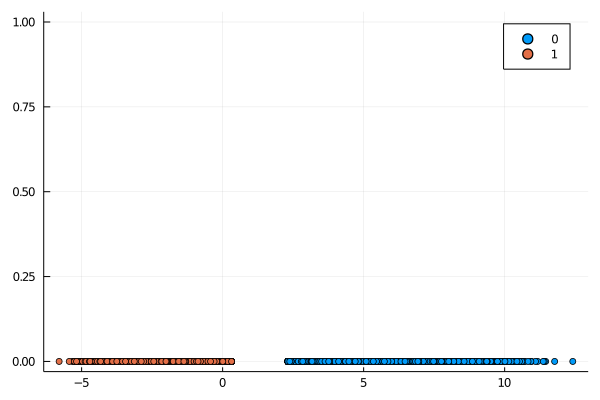

In [22]:
# Make a projection to view separation
gr(fmt=:png)
scatter(features' * β, zeros(size(features,2)), group = labels, legend = true)